In [1]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from harmony import harmonize
from anndata import AnnData
import anndata
from sklearn.utils import shuffle
import copy
import matplotlib.pyplot as plt
import xgboost as xgb
import anndata as ad
import importlib
import PlotConfusion as pc
importlib.reload(pc)
import PlotConfusion as pc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


In [3]:
adata = sc.read_h5ad('path/to/adatasP7b2_adata_typed.h5ad')

In [4]:
1- len(adata[adata.obs['P56_type'] == 0].obs)/len(adata.obs)

0.9813593862383122

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


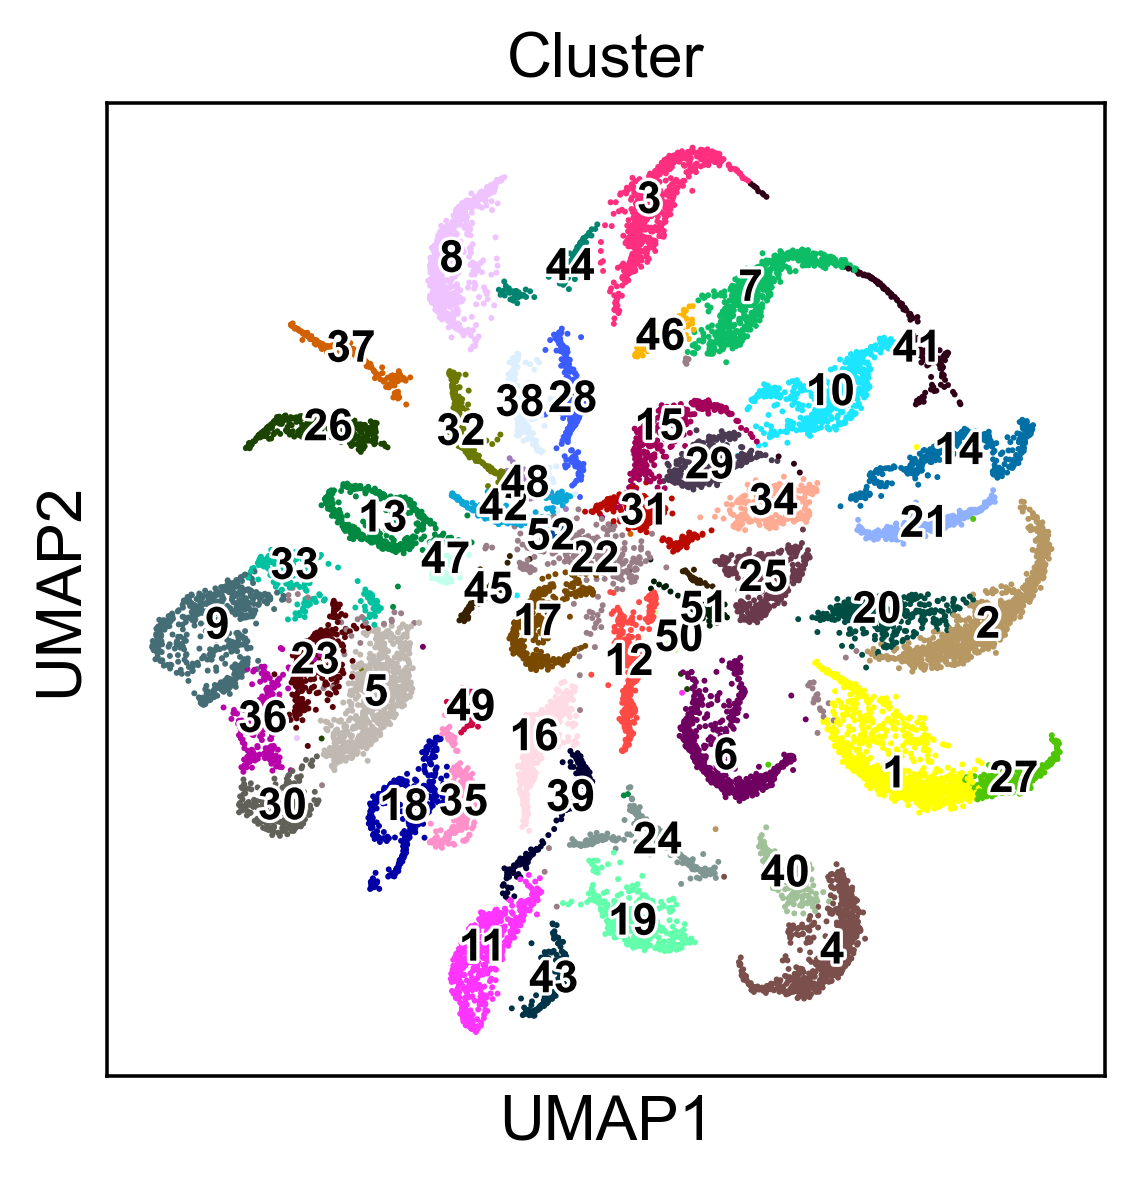

In [8]:
sc.set_figure_params(dpi=160)
sc.pl.umap(adata, color=['Cluster'], legend_loc='on data', legend_fontoutline=1.5, legend_fontsize=10)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


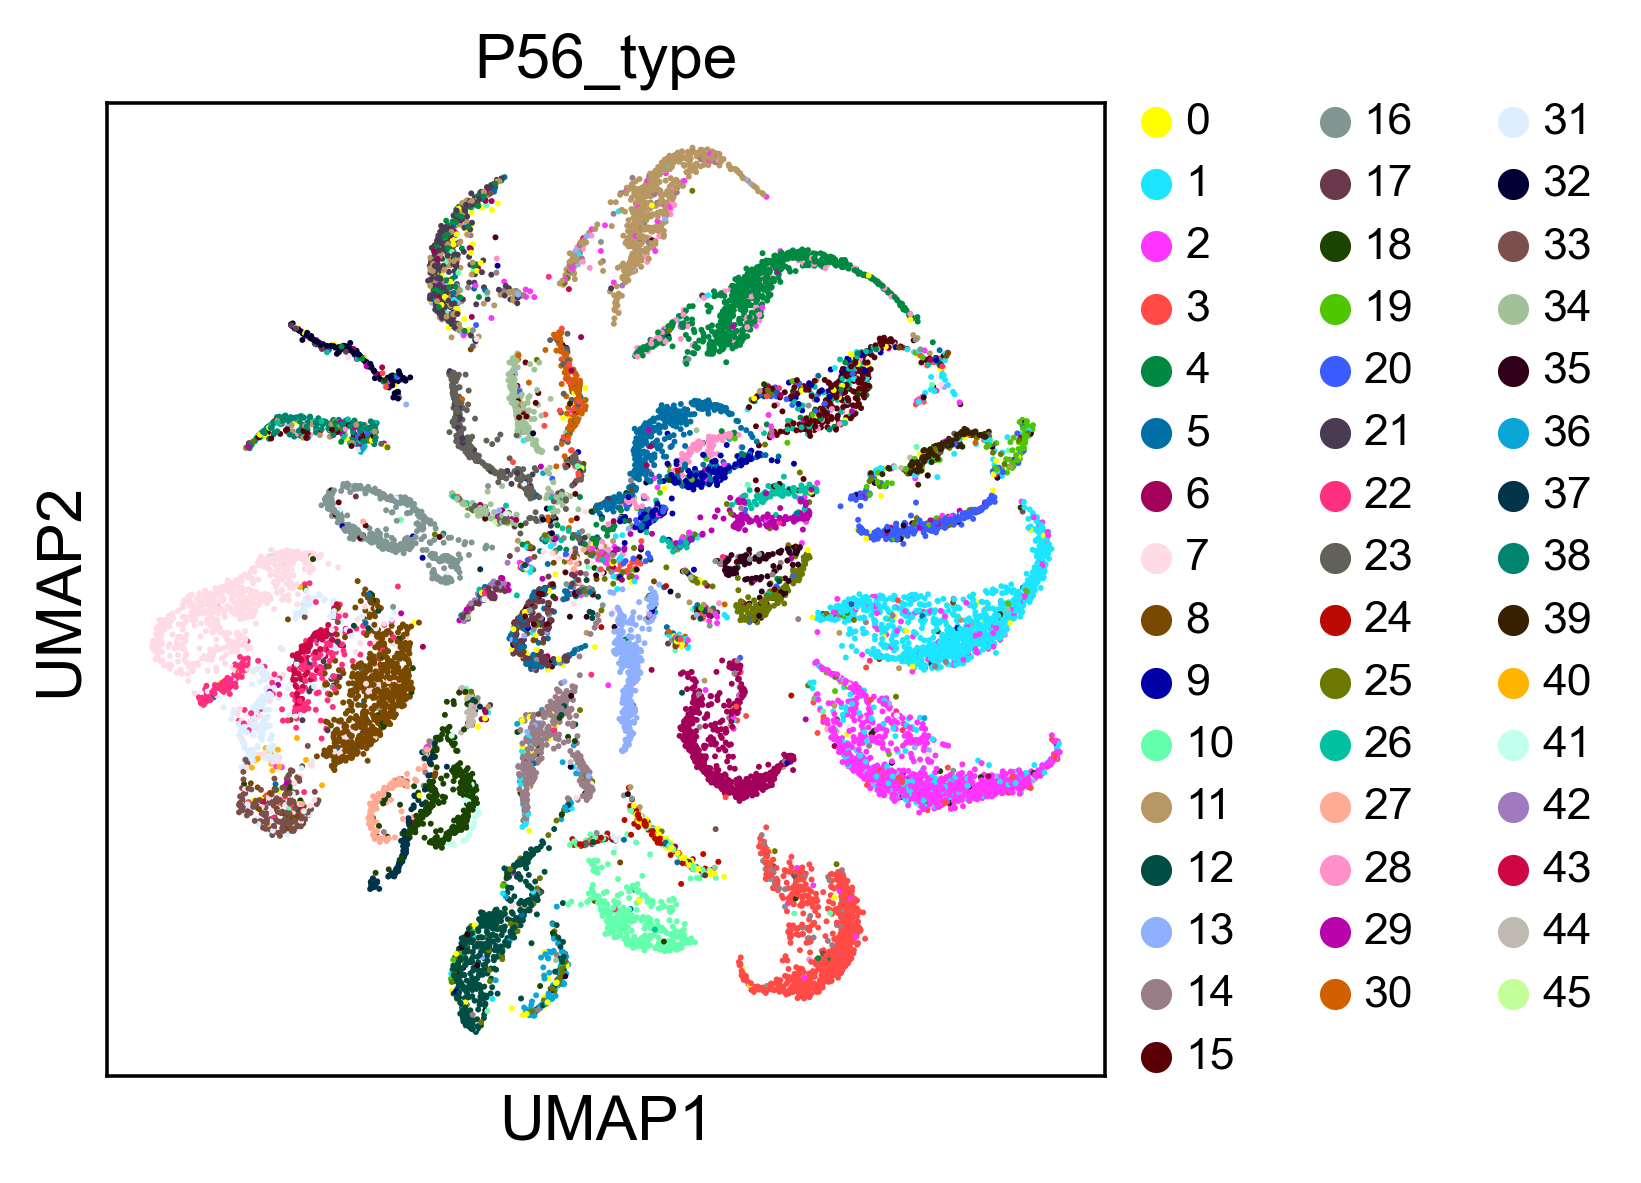

In [9]:
sc.set_figure_params(dpi=160)
sc.pl.umap(adata, color=['P56_type'], legend_fontoutline=1.5, legend_fontsize=10)

In [10]:
adata.uns['log1p']['base'] = None

In [11]:
sc.tl.rank_genes_groups(adata, 'Cluster', method='wilcoxon')

ranking genes


C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_g

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:13)


In [12]:
cluster_count = len(adata.obs['Cluster'].cat.categories)
cluster_list = [str(i+1) for i in range(cluster_count)]
de_df_dict = {}
for i in cluster_list:
    de_df_dict[i] = sc.get.rank_genes_groups_df(adata, i, pval_cutoff=0.05).sort_values('logfoldchanges', ascending=False)

In [ ]:
for i in de_df_dict.keys():
    gene_list = list(de_df_dict[i].names)[:20]
    sc.pl.dotplot(adata, gene_list, 'Cluster', categories_order=cluster_list, title=i, swap_axes=True)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


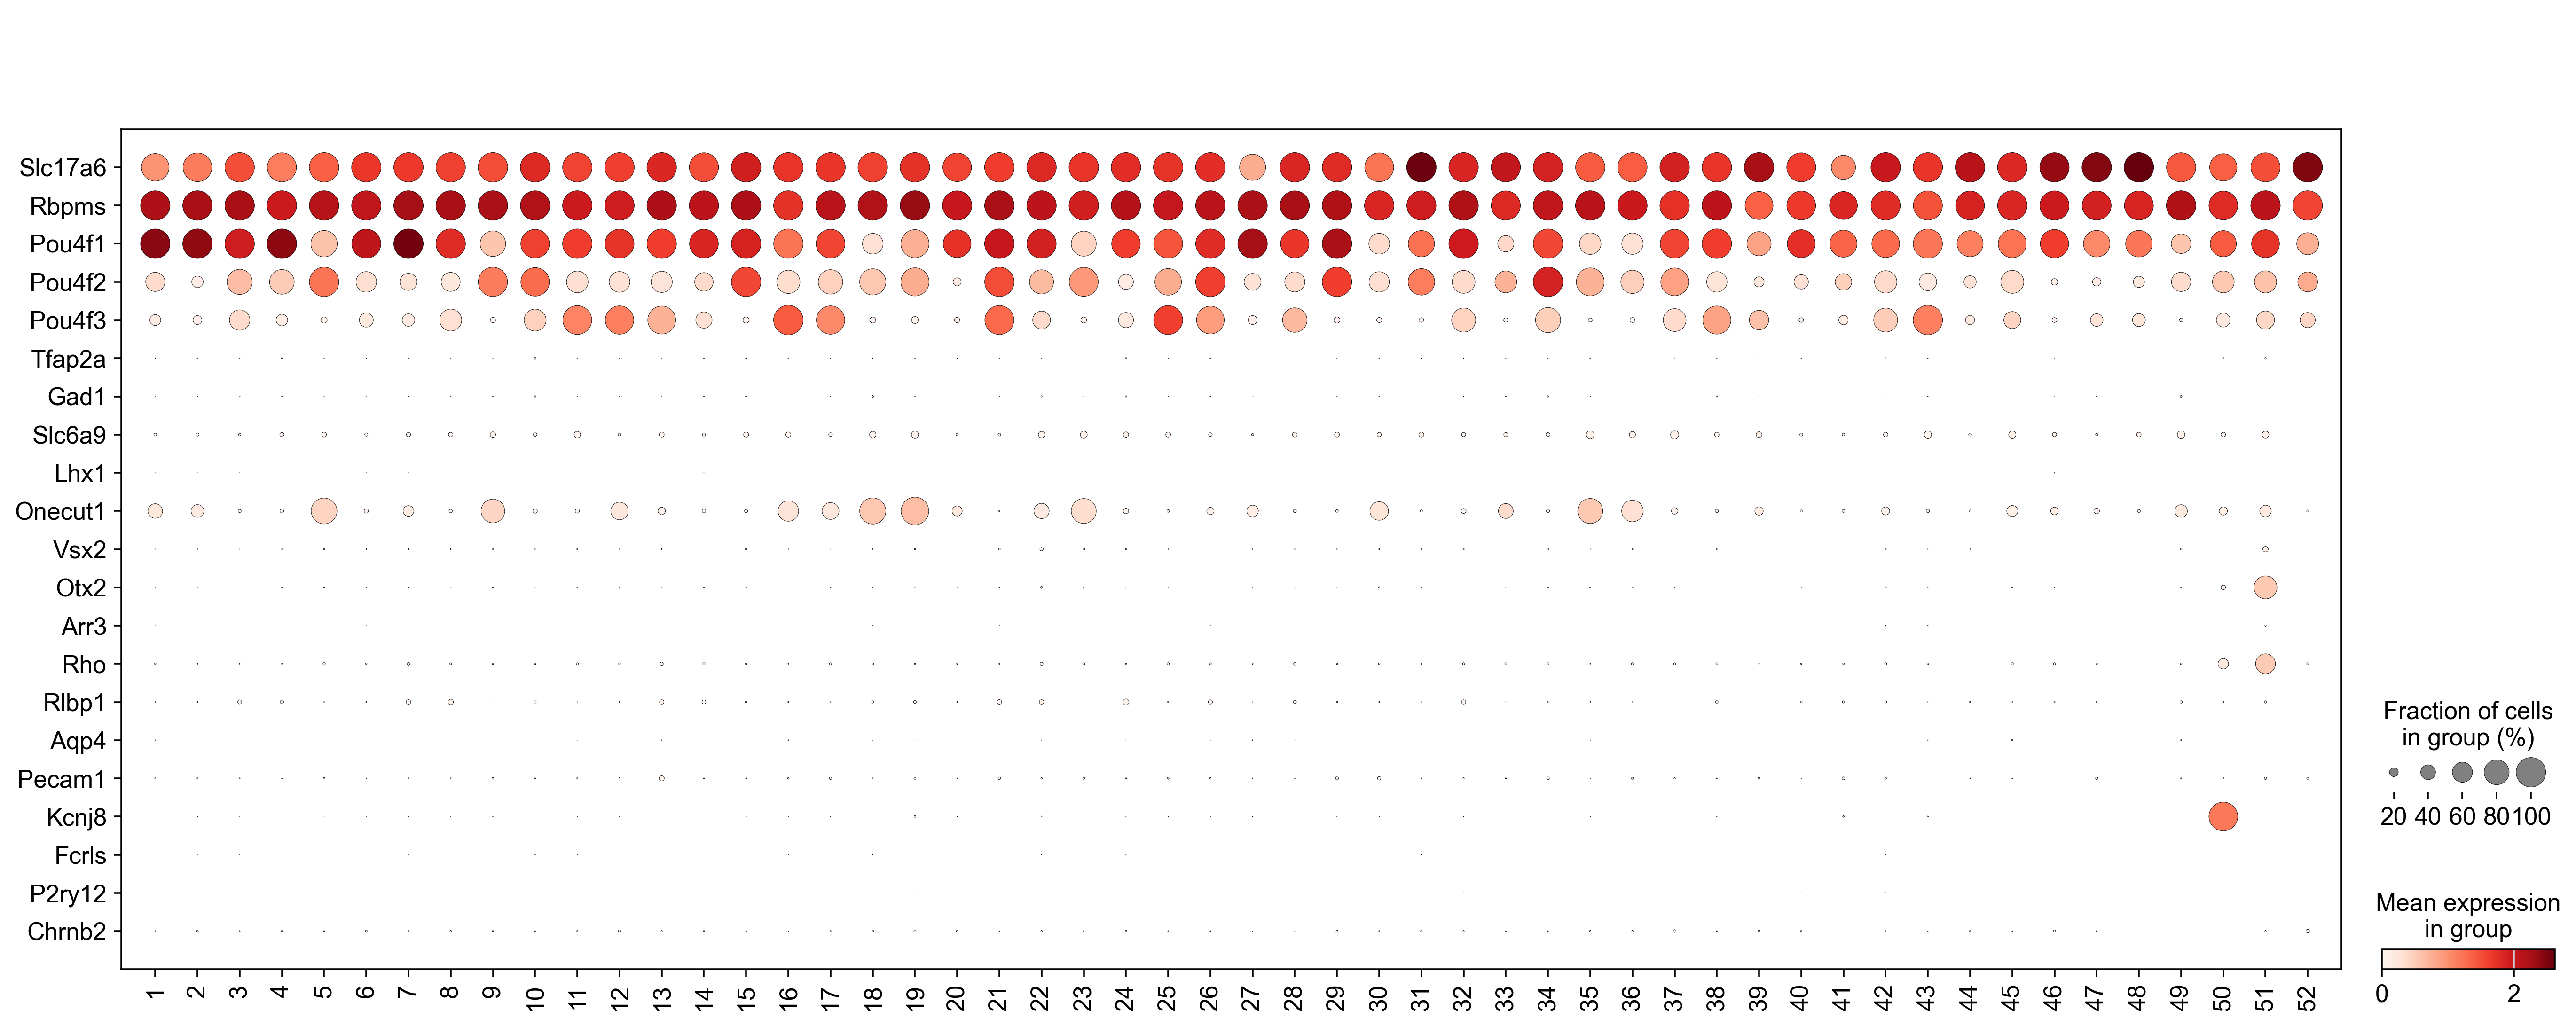

In [14]:
class_markers = ['Slc17a6', 'Rbpms', 'Pou4f1', 'Pou4f2', 'Pou4f3', 'Tfap2a', 'Gad1', 'Slc6a9', 'Lhx1', 'Onecut1', 'Vsx2', 'Otx2', 'Arr3', 'Rho', 'Rlbp1', 'Aqp4', 'Pecam1', 'Kcnj8', 'Fcrls', 'P2ry12', 'Chrnb2']
sc.pl.dotplot(adata, class_markers, 'Cluster', categories_order=cluster_list, swap_axes=True)

In [15]:
prune_clusters = [22, 50, 51]

In [16]:
for i in prune_clusters:
    test = adata[adata.obs['Type_num'] == i]
    pcts = []
    for j in range(45):
        type = j+1
        pcts.append(len(test[test.obs['P56_type'] == j].obs)/len(test))
    print(np.argmax(pcts)+1, pcts[np.argmax(pcts)])

5 0.08524590163934426
2 0.2
12 0.10714285714285714


In [17]:
total_pruned = 0
for i in prune_clusters:
    test = adata[adata.obs['Type_num'] == i]
    pcts = []
    print(i, len(test[test.obs['P56_type'] == 24].obs))
    total_pruned += len(test[test.obs['P56_type'] == 24].obs)

22 1
50 0
51 1


In [18]:
total_pruned

2

In [19]:
adata_pruned = adata[~adata.obs['Cluster'].isin(prune_clusters)]
adata_pruned = adata_pruned[adata_pruned.obs['P56_type'] != 0]

In [44]:
adata_pruned

AnnData object with n_obs × n_vars = 15961 × 775
    obs: 'Batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_raw', 'leiden', 'Cluster', 'Class', 'Type_num', 'Atlas_batch', 'P56_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Cluster_colors', 'P56_type_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'rank_genes_groups'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [45]:
15961/16684

0.9566650683289379

In [20]:
sc.pp.scale(adata_pruned, max_value=10)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
sc.tl.pca(adata_pruned, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [22]:
Z = harmonize(adata_pruned.obsm['X_pca'], adata_pruned.obs, batch_key = 'Batch')
adata_pruned.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
Reach convergence after 7 iteration(s).


In [23]:
sc.pp.neighbors(adata_pruned, n_neighbors=15, use_rep='X_harmony', knn=True)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:06)


In [24]:
sc.tl.umap(adata_pruned)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [25]:
sc.tl.leiden(adata_pruned, resolution=0.5)

running Leiden clustering
    finished: found 34 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [26]:
cluster_nums = []
for i in range(adata_pruned.shape[0]):
    cluster_num = int(adata_pruned.obs.leiden[i])+1
    cluster_num = str(cluster_num)
    cluster_nums.append(cluster_num)

adata_pruned.obs['Cluster'] = pd.Categorical(cluster_nums)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


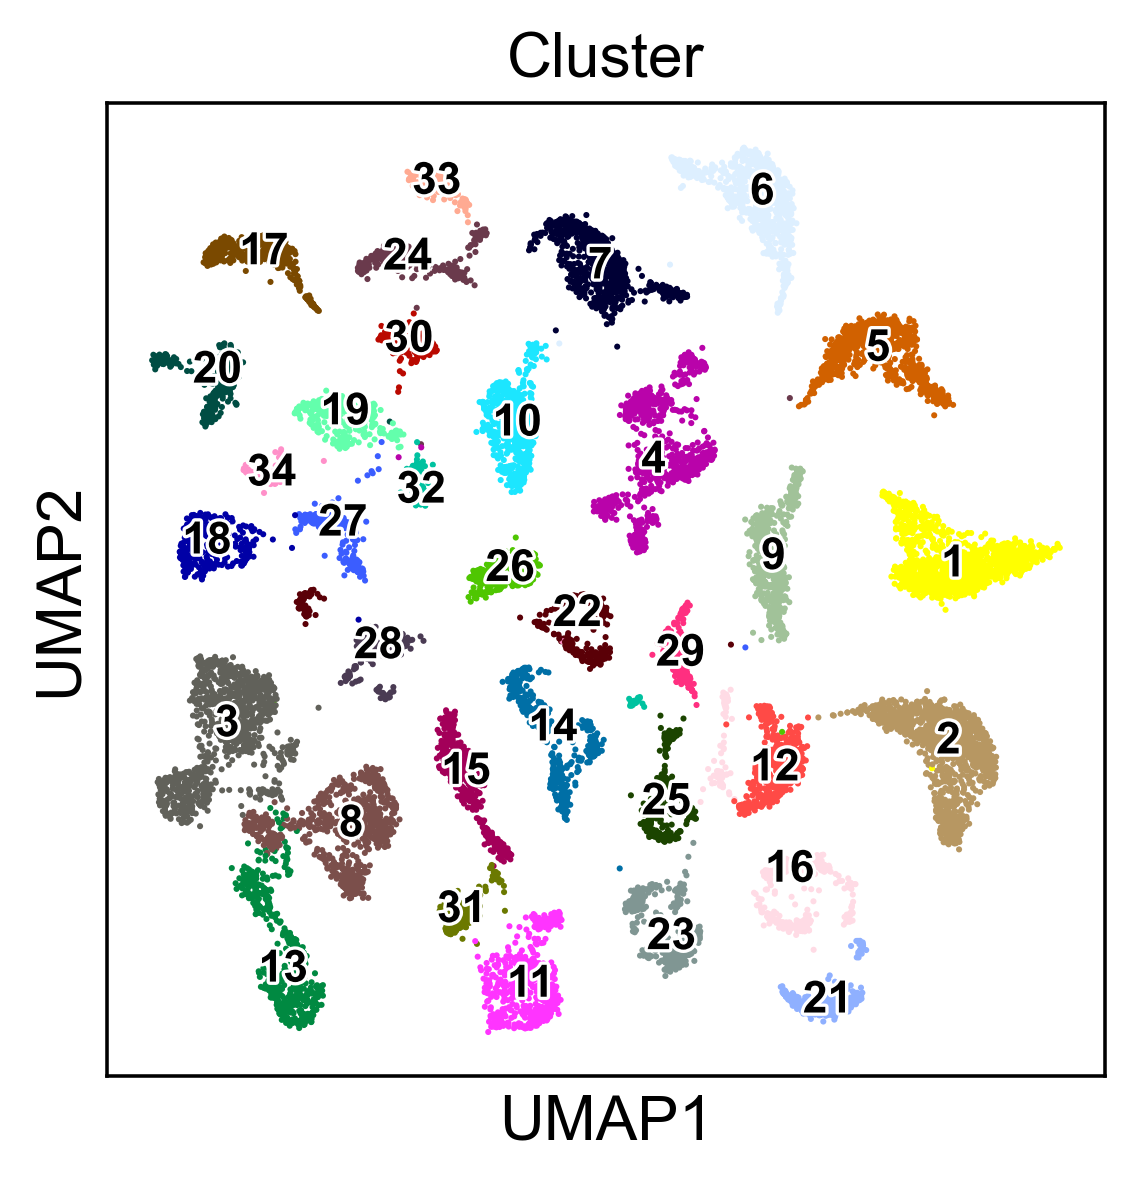

In [27]:
sc.set_figure_params(dpi=160)
sc.pl.umap(adata_pruned, color=['Cluster'], legend_loc='on data', legend_fontoutline=1.5, legend_fontsize=10)

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


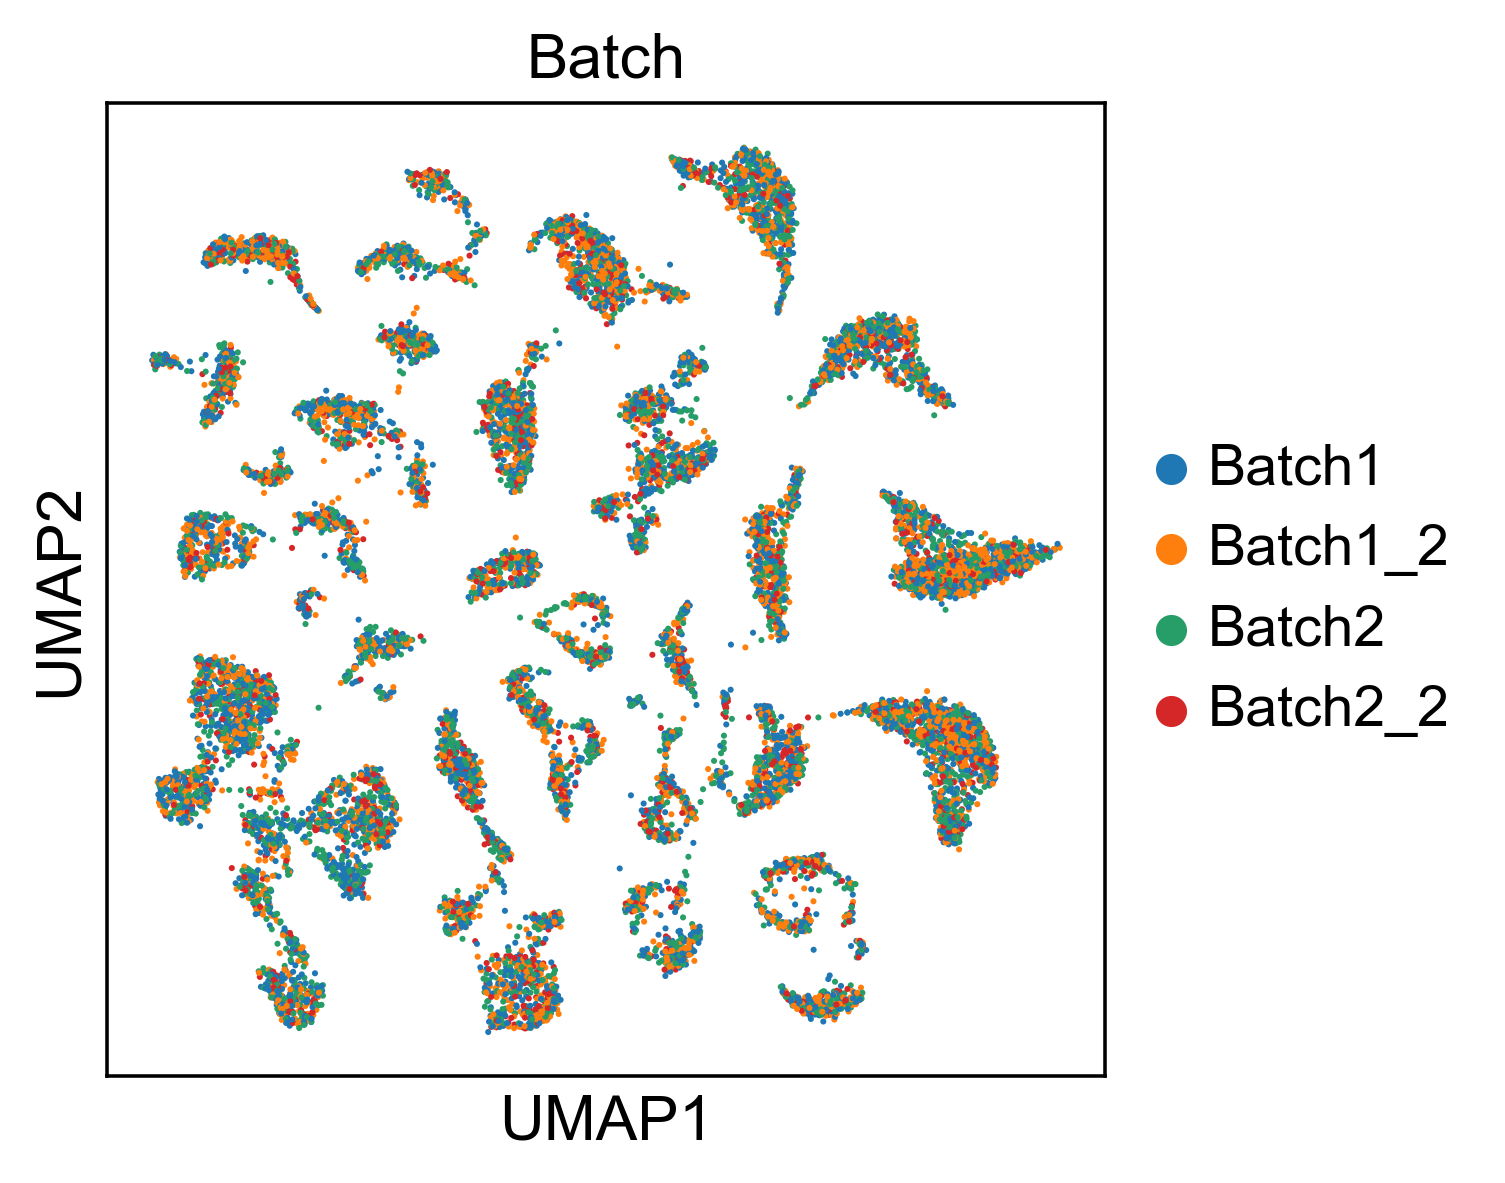

In [28]:
sc.pl.umap(shuffle(adata_pruned), color=['Batch'])

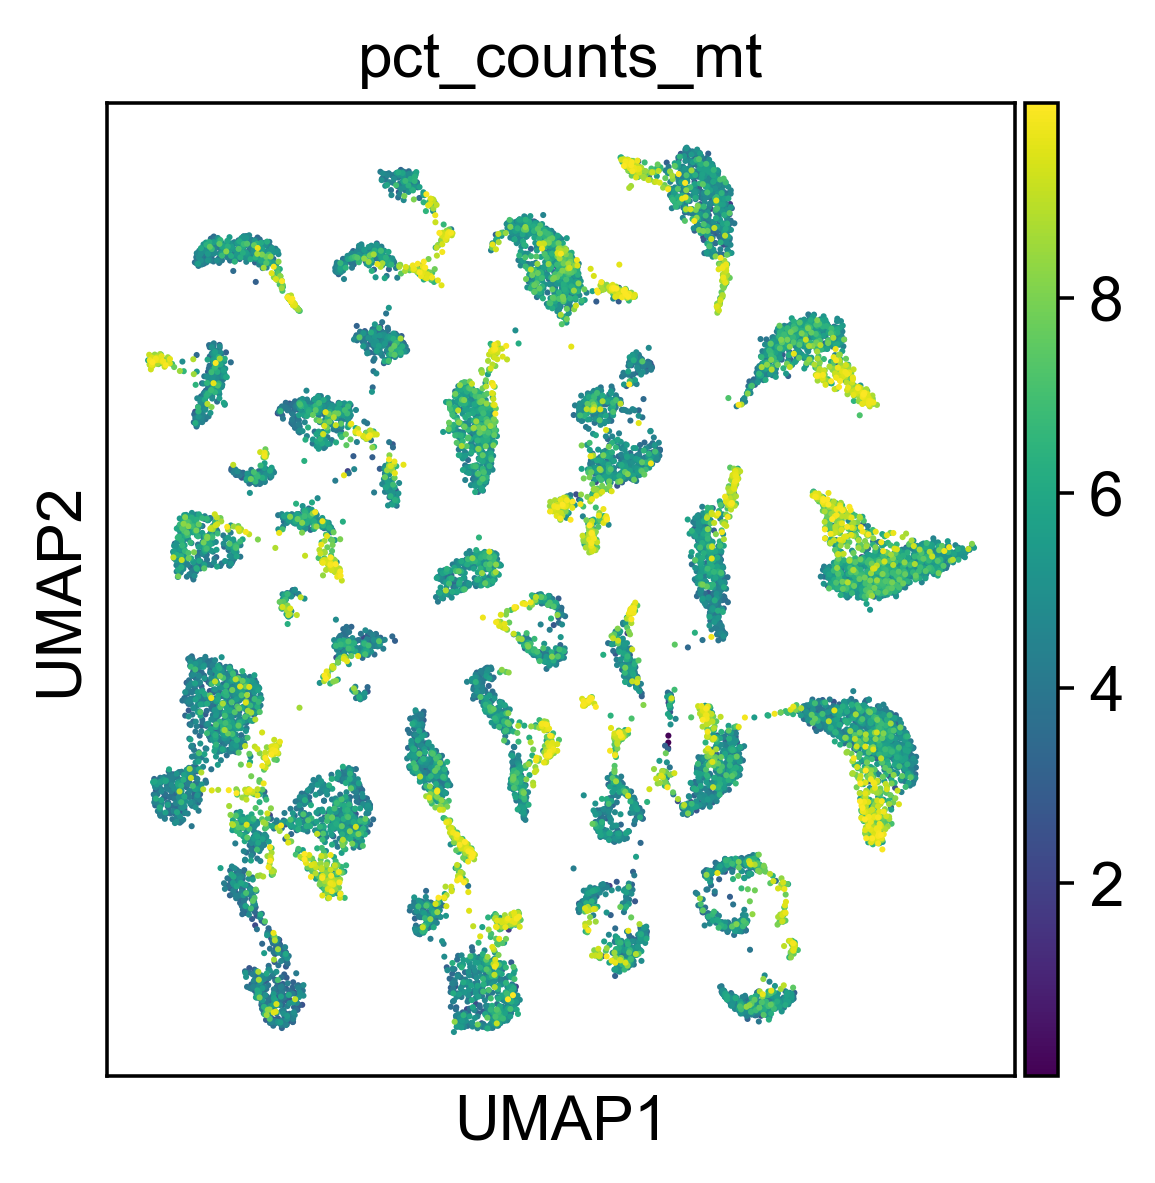

In [29]:
sc.pl.umap(adata_pruned, color=['pct_counts_mt'])

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


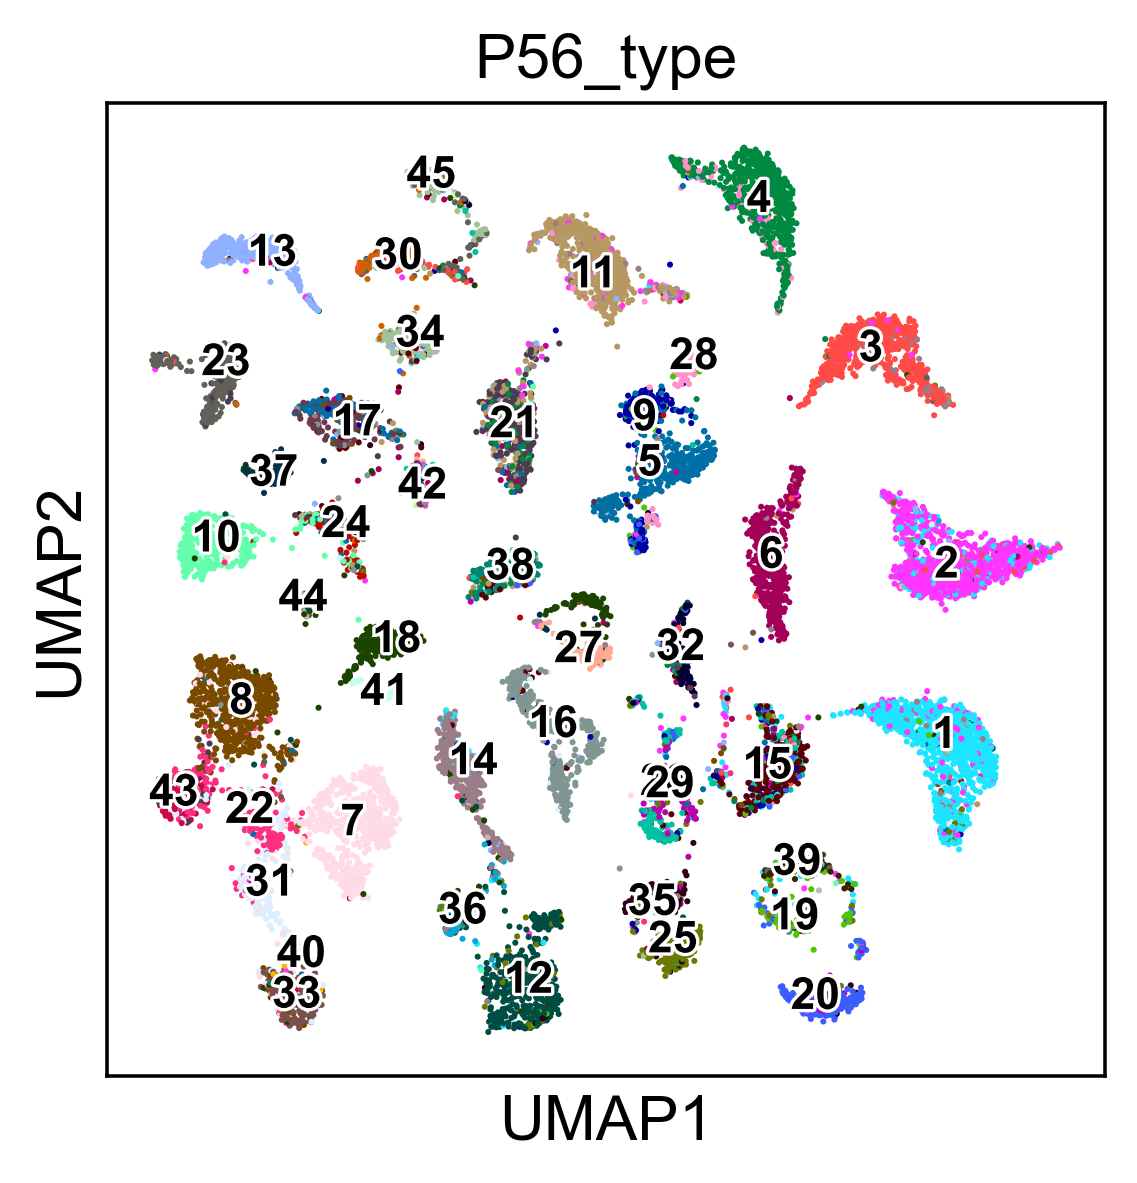

In [30]:
sc.pl.umap(adata_pruned, color=['P56_type'], legend_loc='on data', legend_fontoutline=1.5, legend_fontsize=10)

In [41]:
adata_pruned.obs_names_make_unique()

In [42]:
adata_pruned.write('path/to/adatasP7b2_adata_pruned.h5ad')